# Сводные таблицы

Мы уже видели возможности по исследованию отношений в наборе данных,
предоставляемые абстракцией GroupBy. Сводная таблица (pivot table) — схожая
операция, часто встречающаяся в электронных таблицах и других программах,
работающих с табличными данными. Сводная таблица получает на входе простые
данные в виде столбцов и группирует записи в двумерную таблицу, обеспечивающую многомерное представление данных. Различие между сводными таблицами и операцией GroupBy иногда неочевидно. Можно представлять
сводные таблицы как многомерную версию агрегирующей функции GroupBy.
То есть вы выполняете операцию «разбить, применить, объединить», но как разбиение, так и объединение происходят не на одномерном индексе, а на двумерной
координатной сетке.

## Данные для примеров работы со сводными таблицами

Для примеров из этого раздела мы воспользуемся базой данных пассажиров парохода «Титаник», доступной через библиотеку Seaborn

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
titanic = sns.load_dataset('titanic')
titanic.shape

(891, 15)

In [2]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


Этот набор данных содержит информацию о каждом пассажире злополучного
рейса, включая пол, возраст, класс, стоимость билета и многое другое.

## Сводные таблицы «вручную»

Чтобы узнать о данных больше, можно начать с группировки пассажиров по полу,
информации о том, выжил ли пассажир, или какой-то их комбинации. Если вы
читали предыдущий раздел, то можете воспользоваться операцией GroupBy. Например, посмотрим на коэффициент выживаемости в зависимости от пола:

In [3]:
titanic.groupby('sex')[['survived']].mean()

,survived
sex,
female,0.742038
male,0.188908


Однако хотелось бы заглянуть немного глубже и увидеть распределение выживших по полу и классу. Говоря языком GroupBy, можно было бы идти следующим
путем: сгруппировать по классу и полу, выбрать выживших, применить агрегирующую функцию среднего значения, объединить получившиеся группы, после чего
выполнить операцию unstack иерархического индекса, чтобы обнажить скрытую
многомерность. В виде кода:

In [4]:
titanic.groupby(['sex', 'class'])['survived'].aggregate('mean').unstack()

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


Это дает нам лучшее представление о том, как пол и класс влияли на выживаемость, но код начинает выглядеть несколько запутанным. Хотя каждый шаг этого
конвейера представляется вполне осмысленным в свете ранее рассмотренных инструментов, такая длинная строка кода не особо удобна для чтения или использования. Двумерный GroupBy встречается настолько часто, что в состав библиотеки
Pandas был включен удобный метод, pivot_table, позволяющий описывать более
кратко данную разновидность многомерного агрегирования.

## Синтаксис сводных таблиц

Вот эквивалентный вышеприведенной операции код, использующий метод pivot_
table объекта DataFrame:

In [5]:
titanic.pivot_table('survived', index='sex', columns='class')

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


Такая запись несравненно удобнее для чтения, чем подход с GroupBy, при том же
результате. Как и можно было ожидать от трансатлантического круиза начала
XX века, судьба благоприятствовала женщинам и первому классу. Женщины из
первого класса выжили практически все (привет, Роуз!), из мужчин третьего
класса выжила только десятая часть (извини, Джек!).

### Многоуровневые сводные таблицы

Группировку в сводных таблицах, как и при операции GroupBy, можно задавать на
нескольких уровнях и с множеством параметров. Например, интересно взглянуть
на возраст в качестве третьего измерения. Разобьем данные на интервалы по возрасту с помощью функции pd.cut:

In [6]:
age = pd.cut(titanic['age'], [0, 18, 80])
age

0      (18.0, 80.0]
1      (18.0, 80.0]
2      (18.0, 80.0]
3      (18.0, 80.0]
4      (18.0, 80.0]
           ...     
886    (18.0, 80.0]
887    (18.0, 80.0]
888             NaN
889    (18.0, 80.0]
890    (18.0, 80.0]
Name: age, Length: 891, dtype: category
Categories (2, interval[int64]): [(0, 18] < (18, 80]]

In [7]:
titanic.pivot_table('survived', ['sex', age], 'class')

class               First    Second     Third
sex    age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 80]  0.972973  0.900000  0.423729
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 80]  0.375000  0.071429  0.133663

Мы можем применить ту же стратегию при работе со столбцами. Добавим сюда
информацию о стоимости билета, воспользовавшись функцией pd.qcut для автоматического вычисления квантилей:

In [8]:
fare = pd.qcut(titanic['fare'], 2)
titanic.pivot_table('survived', ['sex', age], [fare, 'class'])

fare            (-0.001, 14.454]                     (14.454, 512.329]  \
class                      First    Second     Third             First   
sex    age                                                               
female (0, 18]               NaN  1.000000  0.714286          0.909091   
       (18, 80]              NaN  0.880000  0.444444          0.972973   
male   (0, 18]               NaN  0.000000  0.260870          0.800000   
       (18, 80]              0.0  0.098039  0.125000          0.391304   

fare                                 
class              Second     Third  
sex    age                           
female (0, 18]   1.000000  0.318182  
       (18, 80]  0.914286  0.391304  
male   (0, 18]   0.818182  0.178571  
       (18, 80]  0.030303  0.192308

Результат представляет собой четырехмерную сводную таблицу с иерархическими
индексами, выведенную
в демонстрирующей отношения между значениями сетке.

### Дополнительные параметы сводных таблиц

Полная сигнатура вызова метода pivot_table объектов DataFrame выглядит следующим образом:

In [9]:
# сигнатура вызова в версии 0.181 библиотеки Pandas
# DataFrame.pivot_table(data, values=None, index=None, columns=None,
# aggfunc='mean', fill_value=None, margins=False,
# dropna=True, margins_name='All')

Ключевое слово aggfunc управляет тем, какой тип агрегирования применяется,
по умолчанию это среднее значение. Как и в GroupBy, спецификация агрегирующей функции может быть строкой с одним из нескольких обычных вариантов
('sum', 'mean', 'count', 'min', 'max' и т. д.) или функцией, реализующей агрегирование (np.sum(), min(), sum() и т. п.). Кроме того, агрегирование может быть
задано в виде словаря, связывающего столбец с любым из вышеперечисленных
вариантов:

In [10]:
titanic.pivot_table(index='sex', columns='class', aggfunc={'survived':sum, 'fare':'mean'})

fare                       survived             
class        First     Second      Third    First Second Third
sex                                                           
female  106.125798  21.970121  16.118810       91     70    72
male     67.226127  19.741782  12.661633       45     17    47

Иногда бывает полезно вычислять итоги по каждой группе. Это можно сделать
с помощью ключевого слова margins:

In [11]:
titanic.pivot_table('survived', index='sex', columns='class', margins=True)

class,First,Second,Third,All
sex,,,,
female,0.968085,0.921053,0.500000,0.742038
male,0.368852,0.157407,0.135447,0.188908
All,0.629630,0.472826,0.242363,0.383838


## Пример: данные о рождаемости 

В качестве примера взглянем на находящиеся в открытом доступе данные о рождаемости в США, предоставляемые центрами по контролю заболеваний (Centers for
Disease Control, CDC). 

In [89]:
# Инструкция системного командного процессора для скачивания данных:
# !curl -O https://raw.githubusercontent.com/jakevdp/data-CDCbirths/
# master/births.csv
births = pd.read_csv(r'CSV\births.csv')

In [90]:
births.head()

,year,month,day,gender,births
0,1969,1,1.0,F,4046
1,1969,1,1.0,M,4440
2,1969,1,2.0,F,4454
3,1969,1,2.0,M,4548
4,1969,1,3.0,F,4548


In [91]:
births['decade'] = 10 * (births['year']//10)
births.pivot_table('births', index='decade', columns='gender', aggfunc='sum')

gender,F,M
decade,,
1960,1753634,1846572
1970,16263075,17121550
1980,18310351,19243452
1990,19479454,20420553
2000,18229309,19106428


Сразу же видим, что в каждом десятилетии мальчиков рождается больше, чем девочек. Воспользуемся встроенными средствами построения графиков библиотеки
Pandas для визуализации общего количества новорожденных в зависимости от года

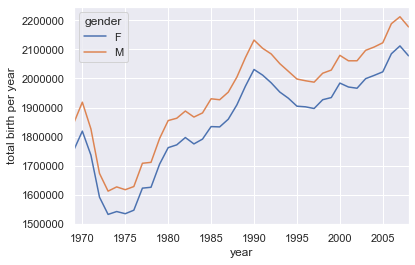

In [92]:
%matplotlib inline
import matplotlib.pyplot as plt
sns.set()  # Используем стили библиотеки Seaborn
births.pivot_table('births', index='year', columns='gender', aggfunc='sum').plot()
plt.ylabel('total birth per year'); # общее количество новорожденных в течение года

Благодаря сводной таблице и методу plot() мы можем сразу же увидеть ежегодный
тренд новорожденных по полу. В последние 50 с лишним лет мальчиков рождалось
больше, чем девочек, примерно на 5 %.

 #### Дальнейшее исследование данных.

Хотя это, возможно, и не имеет отношения
к сводным таблицам, есть еще несколько интересных вещей, которые можно
извлечь из этого набора данных с помощью уже рассмотренных инструментов
библиотеки Pandas. Нам придется начать с небольшой очистки данных, удалив
аномальные значения, возникшие из-за неправильно набранных дат (например,
31 июня) или отсутствующих значений (например, 99 июня). Простой способ
убрать сразу их все — отсечь аномальные значения. Мы сделаем это с помощью
надежного алгоритма сигма-отсечения (sigma-clipping):

In [93]:
quartiles = np.percentile(births['births'], [25, 50, 75])
quartiles

array([4358. , 4814. , 5289.5])

In [94]:
mu = quartiles[1]
sig = 0.74 * (quartiles[2] - quartiles[0])

Последняя строка представляет собой грубую оценку среднего значения выборки,
в котором 0.74 — межквартильный размах Гауссового распределения. Теперь можно
воспользоваться методом query() (обсуждаемым далее в разделе «Увеличение производительности библиотеки Pandas: eval() и query()» этой главы) для фильтрации
строк, в которых количество новорожденных выходит за пределы этих значений:

In [95]:
births = births.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)') 

Далее мы устанавливаем целочисленный тип столбца для day. Ранее он был
строчным, поскольку некоторые столбцы в наборе данных содержат значение
'null':

In [96]:
# делаем тип столбца 'day' целочисленным;
# изначально он был строчным из-за пустых значений
births['day'] = births['day'].fillna(0).astype(int)
births.head()

,year,month,day,gender,births,decade
0,1969,1,1,F,4046,1960
1,1969,1,1,M,4440,1960
2,1969,1,2,F,4454,1960
3,1969,1,2,M,4548,1960
4,1969,1,3,F,4548,1960


Наконец, мы можем создать индекс для даты, объединив день, месяц и год (см.
«Работа с временными рядами» этой главы). Это даст нам возможность быстро
вычислять день недели для каждой строки:

In [97]:
# создаем индекс для даты из года, месяца и дня
births.index = pd.to_datetime(10000 * births.year + 100 * births.month + births.day, format='%Y%m%d')
births['dayofweek'] = births.index.dayofweek # День недели

In [98]:
births['dayofweek']

1969-01-01    2
1969-01-01    2
1969-01-02    3
1969-01-02    3
1969-01-03    4
             ..
1988-12-29    3
1988-12-30    4
1988-12-30    4
1988-12-31    5
1988-12-31    5
Name: dayofweek, Length: 14610, dtype: int64

С помощью этого можно построить график дней рождения в зависимости от дня
недели за несколько десятилетий

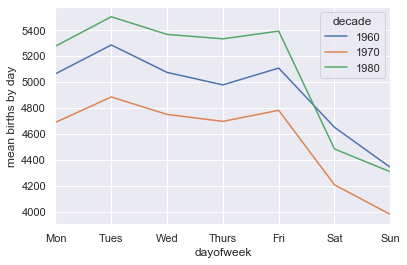

In [99]:
import matplotlib.pyplot as plt
import matplotlib as mpl

births.pivot_table('births', index = 'dayofweek', columns='decade', aggfunc='mean').plot()
plt.gca().set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.ylabel('mean births by day'); # среднее количество новорожденных в день

Становится очевидно, что в выходные происходит меньше рождений, чем в будние дни! Обратите внимание, что 1990-е и 2000-е годы отсутствуют на графике,
поскольку начиная с 1989 года данные CDC содержат только месяц рождения.

Еще одно интересное представление этих данных можно получить, построив график рождений в зависимости от дня года. Сначала сгруппируем данные отдельно
по месяцу и дню:

In [105]:
births_by_date = births.pivot_table('births', [births.index.month, births.index.day])
births_by_date.head()

births
1 1  4009.225
  2  4247.400
  3  4500.900
  4  4571.350
  5  4603.625

Результат представляет собой мультииндекс по месяцам и дням. Чтобы упростить
построение графика, преобразуем эти месяцы и дни в даты путем связывания их
с фиктивным годом (обязательно выберите високосный год, чтобы обработать
29 февраля корректным образом!)

In [106]:
births_by_date.index = [pd.datetime(2012, month, day) for (month, day) in births_by_date.index]
births_by_date.head()

,births
2012-01-01,4009.225
2012-01-02,4247.400
2012-01-03,4500.900
2012-01-04,4571.350
2012-01-05,4603.625


Если смотреть только на месяц и день, то мы получаем временной ряд, отражающий среднее количество новорожденных в зависимости от дня года. Исходя из
этого, мы можем построить с помощью метода plot график данных . В нем
мы обнаруживаем некоторые любопытные тренды:

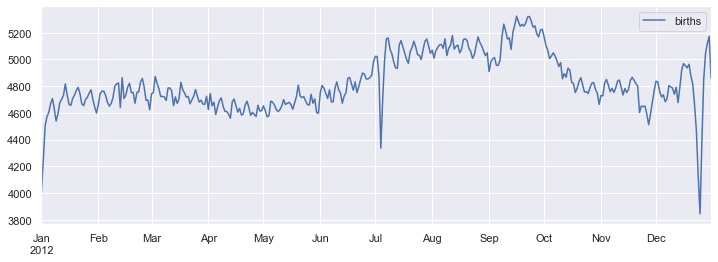

In [109]:
fig, ax = plt.subplots(figsize=(12, 4))
births_by_date.plot(ax=ax);

В частности, на графике удивляет резкое падение количества рождений в государственные праздники США (например, День независимости, День труда, День
благодарения, Рождество, Новый год). Хотя оно отражает скорее тенденции,
относящиеся к заранее запланированным/искусственным родам, а не глубокое психосоматическое влияние на естественные роды.

Глядя на этот краткий пример, вы могли заметить, что многие из рассмотренных
нами инструментов языка Python и библиотеки Pandas можно комбинировать
между собой и использовать, чтобы почерпнуть полезную информацию из множества наборов данных. Более сложные манипуляции над данными мы увидим
в следующих разделах!